In [102]:
# Import built-in libraries
from collections import defaultdict
from glob import glob
import os
from pathlib import Path
import random
import re
import warnings
from sklearn.preprocessing import MinMaxScaler
# Import third party libraries
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from PIL import Image
import seaborn as sns
from skimage.io import imread
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    classification_report,
    accuracy_score
)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# from sklearn import svm
from sklearn.svm import SVC
import tensorflow as tf

# Remove warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [75]:
def find_files(dir_path, format='png'):
    '''Return a list of Path objects of all files in `dir_path` 
    that have the given extention.
    
    Parameters
    ----------
    dir_path : `str` or `path-like`
        Base image directory, in this particular case, it'd be
        '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/'
    extension : `str`
        string at the end of target file names.

    Raises
    ------
    FileNotFoundError
        When `dir_path` doesn't exist.
    
    Returns
    -------
    list
        list of Path objects of all the png files in the base dir.
    '''
    dir_path = Path(dir_path)
    if not dir_path.exists():
        raise FileNotFoundError('`dir_path` doesn\'t exist')

    # For results
    path_list = []  # To store Paths of png files

    for item in dir_path.iterdir():
        # If the item is a directory, call this function
        if item.is_dir():

            # Skip if the directory name starts with '.', based on
            # `mylistdir` above.
            if item.name.startswith('.'):
                continue

            temp_path_list = find_files(item, format='png')
            path_list.extend(temp_path_list)
            
        # If the item name ends with '.png', add to the list
        elif item.name.endswith(f'.{format}'):
            path_list.append(item)

    return path_list

In [76]:
def count_files(path_list):
    '''Count how many files are in each of directories.
    Any path in the `path_list` is expected to be:
    1) a file path
    2) direct parent dir is study dir and grand parent is patient dir:
        e.g. '../patient11599/study1_negative/image.png'
    
    Parameters
    ----------
    path_list : list of Path obj
        list of image file paths
    
    Raises
    ------
    ValueError
        1) When `path_list` contains a directory path
        2) When a path in `path_list` is not following the expected dir pattern.
        
    Returns
    -------
    pandas.DataFrame
        df with three columns, `patient_dir`, `study_dir`, and `count`.    
    '''
    count = []
    pattern = re.compile(r'/(?P<patient>patient\d+)/(?P<study>study\d+_\w+)/')
    
    for item in path_list:
        if item.is_dir():
            raise ValueError(
                f'`path_list` contains a directry, supposed to be a file: {item}'
            )

        abs_path = item.resolve()
        m = pattern.search(str(abs_path))
        if m is None:
            raise ValueError(
                'an image file is supposed to be in patient and study directory:',
                f'{abs_path}'
            )
        patient_dir = m.group('patient')
        study_dir = m.group('study')
        count.append([patient_dir, study_dir])

    df = pd.DataFrame(count, columns=['patient_dir', 'study_dir'])
    df = df.groupby(['patient_dir', 'study_dir']).size().reset_index().rename(columns={0: 'count'})  # Rename the column of size
    
    return df

In [77]:
def count_files(path_list):
    '''Count how many files are in each of directories.
    Any path in the `path_list` is expected to be:
    1) a file path
    2) direct parent dir is study dir and grand parent is patient dir:
        e.g. '../patient11599/study1_negative/image.png'
    
    Parameters
    ----------
    path_list : list of Path obj
        list of image file paths
    
    Raises
    ------
    ValueError
        1) When `path_list` contains a directory path
        2) When a path in `path_list` is not following the expected dir pattern.
        
    Returns
    -------
    pandas.DataFrame
        df with three columns, `patient_dir`, `study_dir`, and `count`.    
    '''
    count = []
    pattern = re.compile(r'/(?P<patient>patient\d+)/(?P<study>study\d+_\w+)/')
    
    for item in path_list:
        if item.is_dir():
            raise ValueError(
                f'`path_list` contains a directry, supposed to be a file: {item}'
            )

        abs_path = item.resolve()
        m = pattern.search(str(abs_path))
        if m is None:
            raise ValueError(
                'an image file is supposed to be in patient and study directory:',
                f'{abs_path}'
            )
        patient_dir = m.group('patient')
        study_dir = m.group('study')
        count.append([patient_dir, study_dir])

    df = pd.DataFrame(count, columns=['patient_dir', 'study_dir'])
    df = df.groupby(['patient_dir', 'study_dir']).size().reset_index().rename(columns={0: 'count'})  # Rename the column of size
    
    return df

In [78]:
def get_data_stats(path_list, output_path=None):
    '''Read RGB png files, collect stats and return the list of stats.
    Parameters
    ----------
    path_list : list of `path-like`
        list of the paths of RGB png files to convert.
    output_path : str or `path-like`, optional
        Output path to export a csv file, if None, it doesn't save satas.
    Raises
    ------
    TypeError
        When `output_path` is not a str nor path-like
    ValueError
        1) When path in `path_list` is not a png file.
        2) When `path_list` contains non RGB colored file.
    Returns
    -------
    pandas.DataFrame
        dataframe of patient name, filename, width, height, file size (KB)
    '''
    #list structure to collect the statistics
    stats = []
    for path in path_list:
        if path.is_dir():
            raise ValueError('`path_list` contains dir path(s).')
        filename = path.name
        abs_path = path.resolve()
        patient = abs_path.parents[1].name
        study = abs_path.parents[0].name
        size_kb = path.stat().st_size / 1000
        img = plt.imread(path, format='png')
        width = img.shape[0]
        height = img.shape[1]
        stats.append([patient, filename, width, height, size_kb])
    df = pd.DataFrame(stats, columns=['Class','Filename', 'Width', 'Height', 'Size_in_KB'])
    if output_path is not None:
        if not isinstance(output_path, str) and not isinstance(output_path, Path):
            raise TypeError('invalid `output_path`.')
        df.to_csv(output_path)
        print(f'stats saved in {output_path}.')
    return df

In [90]:
# run all the process
base_dir = '/Users/adejuwon/MURA-v1.1/valid/XR_FINGER/'

# Get the paths of png files
path_list = find_files(base_dir)

# Count files in each directory
count_df = count_files(path_list)

# Get the stats of the files
stats_df = get_data_stats(path_list)

# Load RGB files
#img_size = 8888  # put in a correct number
#images, labels = load_rgb_data_cv(path_list, img_size)

In [91]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [92]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))# Distribution graphs (histogram/bar graph) of column data
df=stats_df
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [93]:
stats_df

,Class,Filename,Width,Height,Size_in_KB
0,patient11935,image1.png,512,379,135.929
1,patient11935,image2.png,512,379,129.132
2,patient11935,image3.png,512,379,118.759
3,patient11935,image1.png,512,406,146.443
4,patient11935,image2.png,512,406,128.313
...,...,...,...,...,...
456,patient11347,image3.png,512,407,51.763
457,patient11949,image1.png,425,512,56.253
458,patient11723,image1.png,512,186,31.903
459,patient11723,image2.png,512,178,28.977


In [94]:
df = stats_df[(stats_df['Width'] <500)]
df

,Class,Filename,Width,Height,Size_in_KB
32,patient11961,image1.png,406,512,100.273
51,patient11960,image1.png,406,512,182.345
52,patient11960,image2.png,406,512,175.531
53,patient11960,image3.png,406,512,177.849
54,patient11958,image1.png,406,512,161.837
66,patient11649,image1.png,406,512,64.985
69,patient11812,image1.png,407,512,56.069
70,patient11812,image1.png,379,512,112.113
71,patient11647,image1.png,406,512,96.664
131,patient11601,image1.png,406,512,143.195


In [95]:
df = stats_df[(stats_df['Height'] >500)]


df2 = df[(df['Width'] < 500)]
df2


,Class,Filename,Width,Height,Size_in_KB
32,patient11961,image1.png,406,512,100.273
51,patient11960,image1.png,406,512,182.345
52,patient11960,image2.png,406,512,175.531
53,patient11960,image3.png,406,512,177.849
54,patient11958,image1.png,406,512,161.837
66,patient11649,image1.png,406,512,64.985
69,patient11812,image1.png,407,512,56.069
70,patient11812,image1.png,379,512,112.113
71,patient11647,image1.png,406,512,96.664
131,patient11601,image1.png,406,512,143.195


In [96]:
stats_df["Width"].min()

379

In [97]:
stats_df["Height"].min()

108

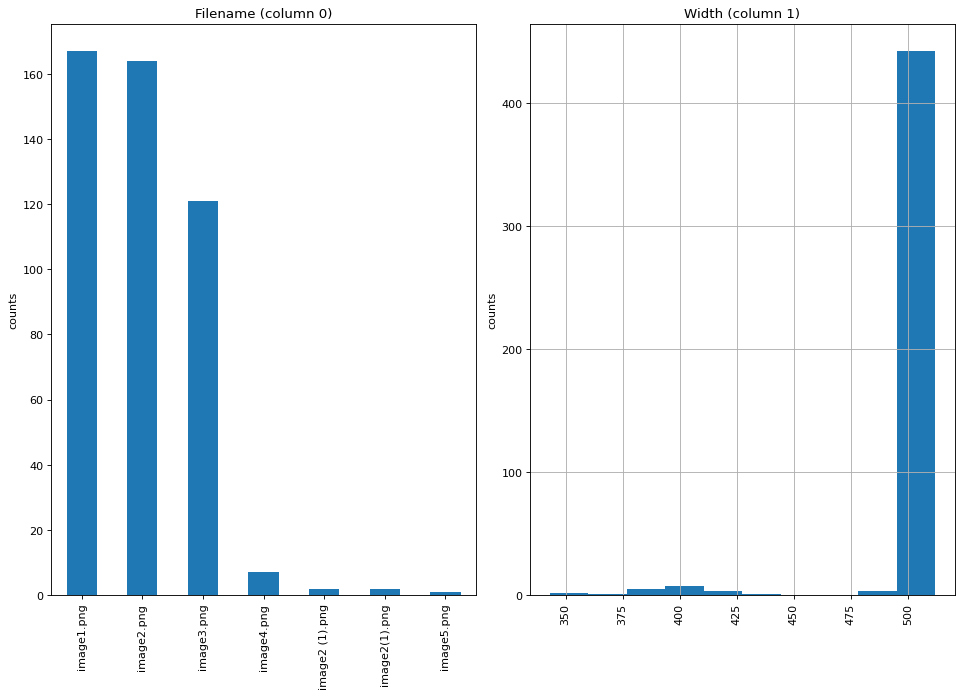

In [31]:
plotPerColumnDistribution(df, 10, 10)

In [34]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    #filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    #plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

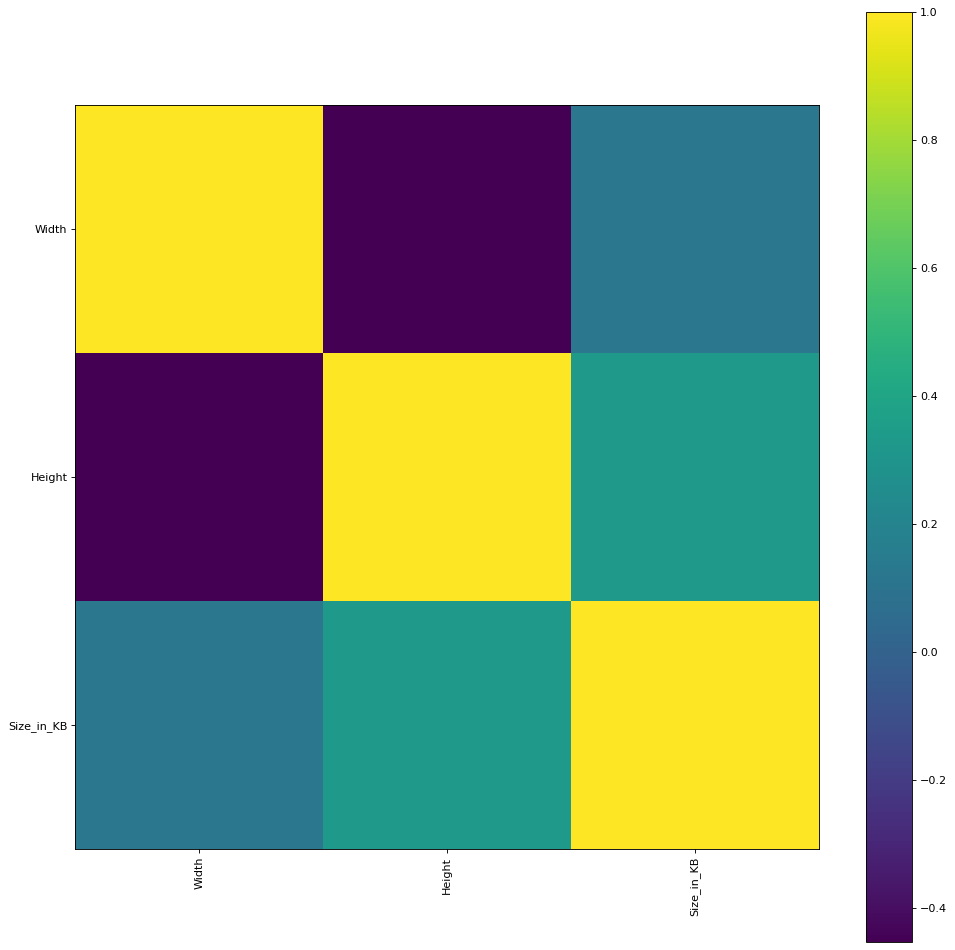

In [35]:
plotCorrelationMatrix(df, 15)

In [26]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

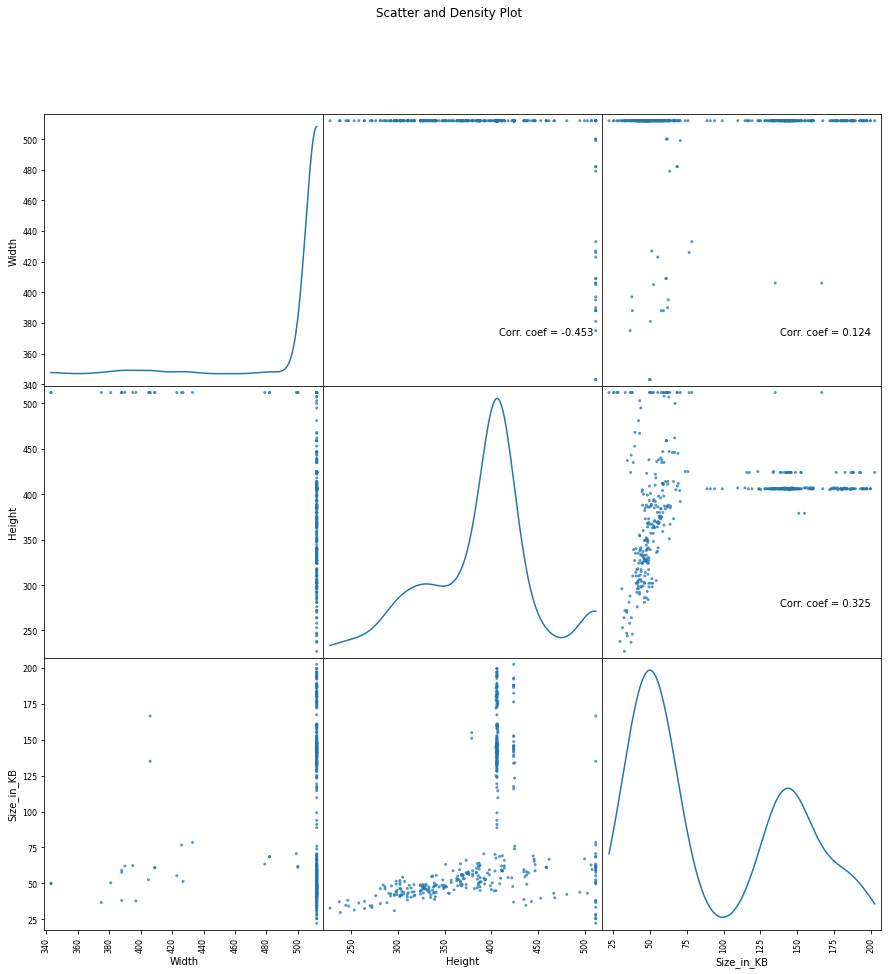

In [27]:
plotScatterMatrix(df, 15, 10)

In [60]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import imageio as io
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser

ValueError: cannot reshape array of size 9 into shape (1,63504)

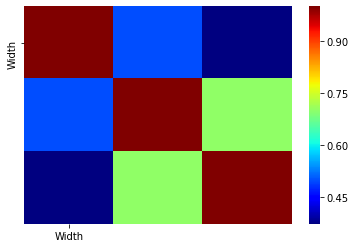

<Figure size 432x288 with 0 Axes>

In [107]:
# =============================================================================
# Normalization
# =============================================================================
#min_max_scaler=MinMaxScaler()
#scores = min_max_scaler.fit_transform(stats_df) 
# =============================================================================
# correlation map and histogram 
# =============================================================================
df = pd.DataFrame(stats_df)             
corrMatrix = df.corr().abs().fillna(0)
fig = plt.figure()
sns.heatmap(corrMatrix,xticklabels=50,yticklabels=50,cmap='jet')
plt.savefig('corr_map',dpi=300,format='eps')
# 
fig = plt.figure()
(h,x)=np.histogram(corrMatrix.to_numpy().reshape(1,252*252), bins=8) 
plt.bar(x[1:],h/(252*252),width=0.1)            
plt.grid(linewidth=.3)  
plt.xlabel('Correlation coefficient value')
plt.ylabel('Frequency percentage (%)')
plt.savefig('corr_hist.jpg',dpi=300)